In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

In [7]:
data_A = pd.read_csv("/home/users/russelld/DSC291/Final_Project/datasets/DetectorA.csv")
data_B = pd.read_csv("/home/users/russelld/DSC291/Final_Project/datasets/DetectorB.csv")
data_C = pd.read_csv("/home/users/russelld/DSC291/Final_Project/datasets/DetectorC.csv")
data_Target = pd.read_csv("/home/users/russelld/DSC291/Final_Project/datasets/DetectorTarget.csv")


<Axes: title={'center': 'Detector A Energy Spectrum'}, xlabel='Energy [keV]', ylabel='Frequency'>

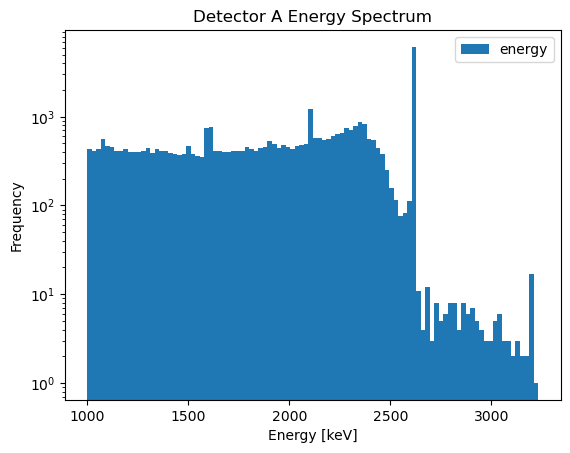

In [8]:
data_A.plot(kind='hist', title='Detector A Energy Spectrum', column='energy', bins=100, logy=True, xlabel="Energy [keV]")

<Axes: title={'center': 'Detector B Energy Spectrum'}, xlabel='Energy [keV]', ylabel='Frequency'>

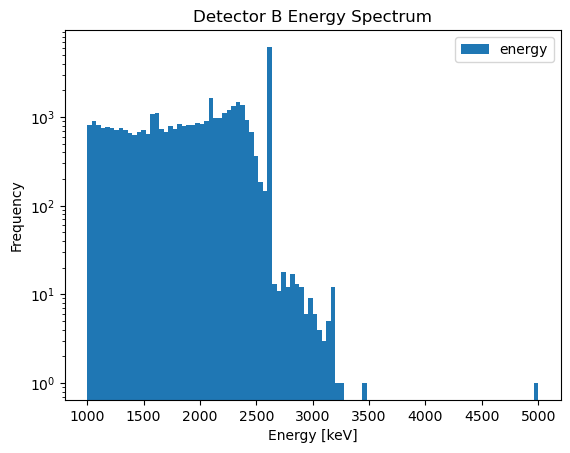

In [9]:
data_B.plot(kind='hist', title='Detector B Energy Spectrum', column='energy', bins=100, logy=True, xlabel="Energy [keV]")

<Axes: title={'center': 'Detector C Energy Spectrum'}, xlabel='Energy [keV]', ylabel='Frequency'>

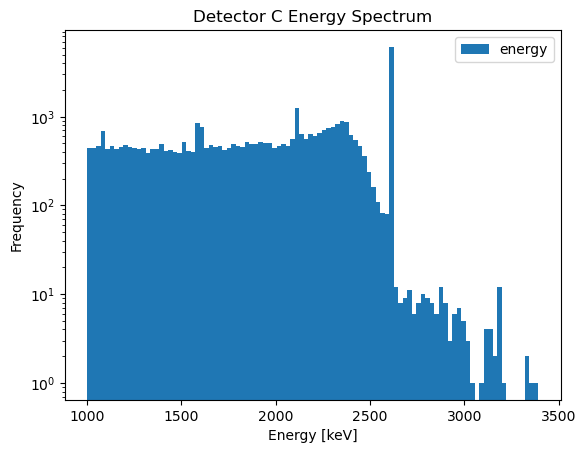

In [10]:
data_C.plot(kind='hist', title='Detector C Energy Spectrum', column='energy', bins=100, logy=True, xlabel="Energy [keV]")

<Axes: title={'center': 'Detector Target Energy Spectrum'}, xlabel='Energy [keV]', ylabel='Frequency'>

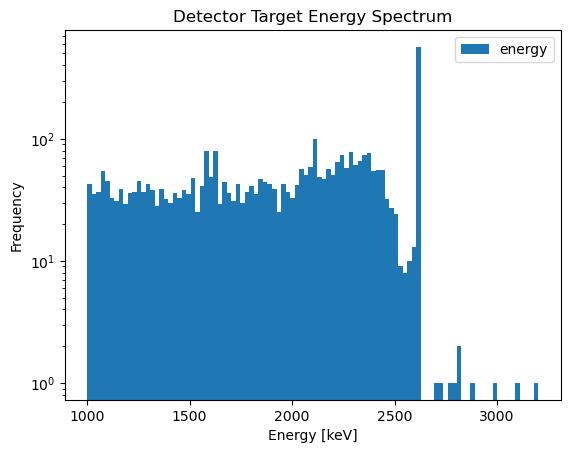

In [11]:
data_Target.plot(kind='hist', title='Detector Target Energy Spectrum', column='energy', bins=100, logy=True, xlabel="Energy [keV]")

step 2: signal peak cut

In [12]:
def calc_cut_eff(Nc, tau, N, B, Bc):
    eff = (Nc-tau*Bc)/(N-tau*B)
    return eff

In [13]:
signal_window_min= 1590
signal_window_max = 1595

sig_base_window_min = 1585
sig_base_window_max = 1590


energies_A = data_A["energy"]
sig_energy = data_A.loc[(data_A['energy'] >= signal_window_min) & (data_A['energy'] <= signal_window_max), 'energy']
base_energy = data_A.loc[(data_A['energy'] >= sig_base_window_min) & (data_A['energy'] <= sig_base_window_max), 'energy']
N_sig = len(sig_energy)
B_sig = len(base_energy)
tau_sig = 1
sig_scores = data_A.loc[(data_A['energy'] >= signal_window_min) & (data_A['energy'] <= signal_window_max), 'cnn_score']
baseline_scores = data_A.loc[(data_A['energy'] >= sig_base_window_min) & (data_A['energy'] <= sig_base_window_max), 'cnn_score'] 
cut_thresh = .15
Nc_sig= len(data_A.loc[(data_A['energy'] >= signal_window_min) & (data_A['energy'] <= signal_window_max) & (data_A['cnn_score']>cut_thresh), 'cnn_score'])
Bc_sig = len(data_A.loc[(data_A['energy'] >= sig_base_window_min) & (data_A['energy'] <= sig_base_window_max) & (data_A['cnn_score']>cut_thresh), 'cnn_score'])
cut_eff = calc_cut_eff(Nc_sig, tau_sig, N_sig, B_sig, Bc_sig)
print("True Positive Rate (Cut efficiency)= ", cut_eff)
print(N_sig, B_sig, Nc_sig, Bc_sig)




True Positive Rate (Cut efficiency)=  0.7690217391304348
454 86 329 46


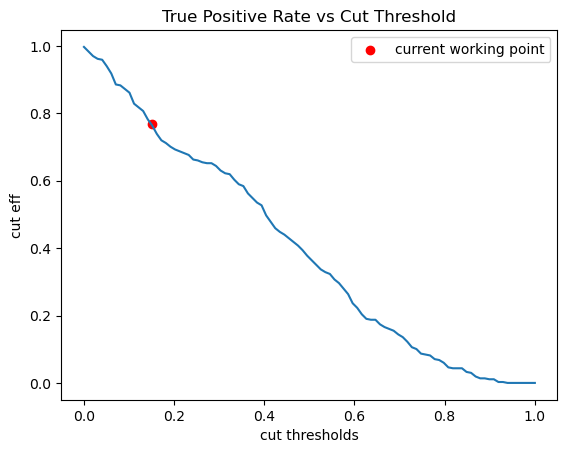

In [14]:

thresholds = np.linspace(0, 1, num=100)
effs = []
for thresh in thresholds:
    Nc= len(data_A.loc[(data_A['energy'] >= signal_window_min) & (data_A['energy'] <= signal_window_max) & (data_A['cnn_score']>thresh), 'cnn_score'])
    Bc = len(data_A.loc[(data_A['energy'] >= sig_base_window_min) & (data_A['energy'] <= sig_base_window_max) & (data_A['cnn_score']>thresh), 'cnn_score'])
    eff = calc_cut_eff(Nc, 1, N_sig, B_sig, Bc)
    effs.append(eff)
    
plt.figure()
plt.plot(thresholds, effs)
plt.scatter(.15,0.7690217391304348, label="current working point", color="red")
plt.legend()
plt.xlabel("cut thresholds")
plt.ylabel("cut eff")
plt.title("True Positive Rate vs Cut Threshold")
plt.show()

Step 3: false positive rate for background peak

In [15]:
bkg_window_min= 2098
bkg_window_max = 2108

bkg_base_window_min = 2093
bkg_base_window_max = 2113


energies_A = data_A["energy"]
bkg_energy = data_A.loc[(data_A['energy'] >= bkg_window_min) & (data_A['energy'] <= bkg_window_max), 'energy']
bkg_base_energy_lower = data_A.loc[(data_A['energy'] >= bkg_base_window_min) & (data_A['energy'] <= bkg_window_min), 'energy']
bkg_base_energy_upper = data_A.loc[(data_A['energy'] >= bkg_window_max) & (data_A['energy'] <= bkg_base_window_max), 'energy']

N_bkg = len(bkg_energy)
B_bkg = len(bkg_base_energy_lower) + len(bkg_base_energy_upper)
tau_bkg = 1
bkg_scores = data_A.loc[(data_A['energy'] >= bkg_window_min) & (data_A['energy'] <= bkg_window_max), 'cnn_score']
# bkg_baseline_scores = data_A.loc[((data_A['energy'] >= bkg_base_window_min) & (data_A['energy'] <= bkg_window_min)) or ((data_A['energy'] >= bkg_window_max) & (data_A['energy'] <= bkg_base_window_max)), 'cnn_score'] 
cut_thresh = .15
Nc_bkg= len(data_A.loc[(data_A['energy'] >= bkg_window_min) & (data_A['energy'] <= bkg_window_max) & (data_A['cnn_score']>cut_thresh), 'cnn_score'])
Bc_bkg = len(data_A.loc[(data_A['energy'] >= bkg_base_window_min) & (data_A['energy'] <= bkg_window_min) & (data_A['cnn_score']>cut_thresh), 'cnn_score']) + len(data_A.loc[(data_A['energy'] >= bkg_window_max) & (data_A['energy'] <= bkg_base_window_max) & (data_A['cnn_score']>cut_thresh), 'cnn_score'])
cut_eff_bkg = calc_cut_eff(Nc_bkg, tau_bkg, N_bkg, B_bkg, Bc_bkg)
print("False Positive Rate (Cut efficiency)= ", cut_eff_bkg)
print(N_bkg, B_bkg, Nc_bkg, Bc_bkg)

False Positive Rate (Cut efficiency)=  0.10058309037900874
933 247 165 96


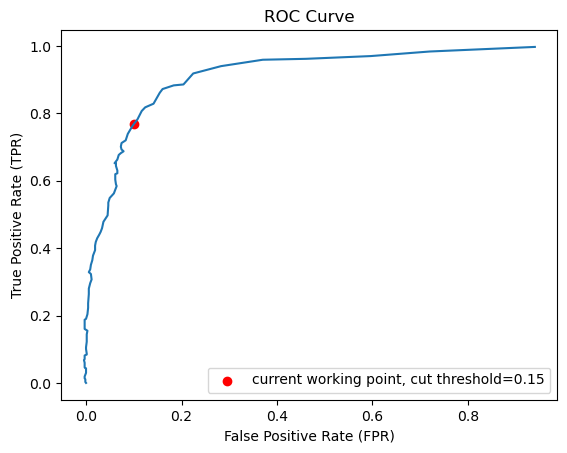

In [16]:
thresholds = np.linspace(0, 1, num=100)
tprs = []
fprs = []
for thresh in thresholds:
    Nc= len(data_A.loc[(data_A['energy'] >= signal_window_min) & (data_A['energy'] <= signal_window_max) & (data_A['cnn_score']>thresh), 'cnn_score'])
    Bc = len(data_A.loc[(data_A['energy'] >= sig_base_window_min) & (data_A['energy'] <= sig_base_window_max) & (data_A['cnn_score']>thresh), 'cnn_score'])
    tpr = calc_cut_eff(Nc, 1, N_sig, B_sig, Bc)
    tprs.append(tpr)

    nc_bkg = len(data_A.loc[(data_A['energy'] >= bkg_window_min) & (data_A['energy'] <= bkg_window_max) & (data_A['cnn_score']>thresh), 'cnn_score']) 
    bc_bkg = len(data_A.loc[(data_A['energy'] >= bkg_base_window_min) & (data_A['energy'] <= bkg_window_min) & (data_A['cnn_score']>thresh), 'cnn_score']) + len(data_A.loc[(data_A['energy'] >= bkg_window_max) & (data_A['energy'] <= bkg_base_window_max) & (data_A['cnn_score']>thresh), 'cnn_score'])
    fpr = calc_cut_eff(nc_bkg, 1, N_bkg, B_bkg, bc_bkg)
    fprs.append(fpr)

    
plt.figure()
plt.plot(fprs, tprs)
plt.scatter(0.10058309037900874, 0.7690217391304348, label="current working point, cut threshold=0.15", color="red")
plt.legend()
plt.title("ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.show()

step 4: PDF for NLDBD

In [17]:
E0= 2039
sigma =1
def nldbd_pdf(x):
    return stats.norm.pdf(x, loc=E0, scale=sigma)

Step 5: apply the cut

In [18]:
data_A_with_cut = data_A.loc[(data_A['cnn_score']>cut_thresh)]
data_B_with_cut = data_B.loc[(data_B['cnn_score']>cut_thresh)]
data_C_with_cut = data_C.loc[(data_C['cnn_score']>cut_thresh)]
data_Target_with_cut = data_Target.loc[(data_B['cnn_score']>cut_thresh)]


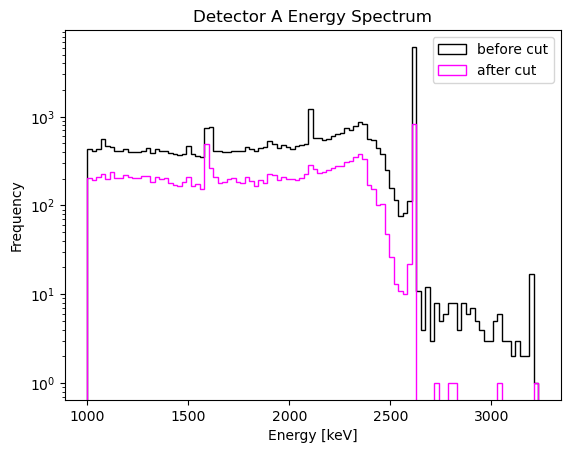

In [19]:
plt.figure()
ax = data_A['energy'].plot(
    kind='hist', 
    title='Detector A Energy Spectrum', 
    bins=100, 
    logy=True, 
    histtype='step',
    label='before cut',
    xlabel="Energy [keV]",
    color="black"
)

data_A_with_cut['energy'].plot(
    kind='hist', 
    ax=ax, 
    bins=100, 
    histtype='step',
    logy=True, 
    label='after cut',
    xlabel="Energy [keV]",
    color="magenta"
)

plt.legend()
plt.show()

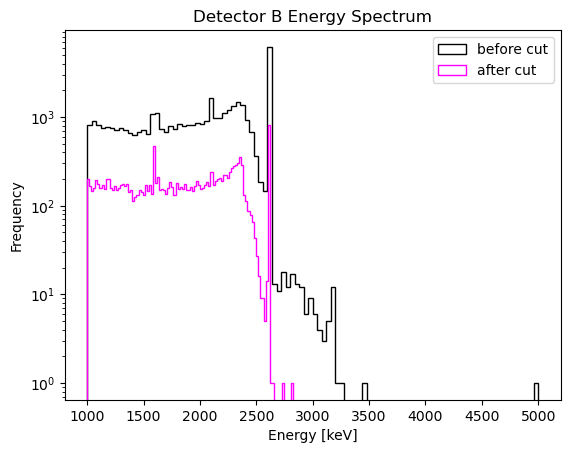

In [20]:
plt.figure()
ax = data_B['energy'].plot(
    kind='hist', 
    title='Detector B Energy Spectrum', 
    bins=100, 
    logy=True, 
    histtype='step',
    label='before cut',
    xlabel="Energy [keV]",
    color="black"
)

data_B_with_cut['energy'].plot(
    kind='hist', 
    ax=ax, 
    bins=100, 
    histtype='step',
    logy=True, 
    label='after cut',
    xlabel="Energy [keV]",
    color="magenta"
)

plt.legend()
plt.show()

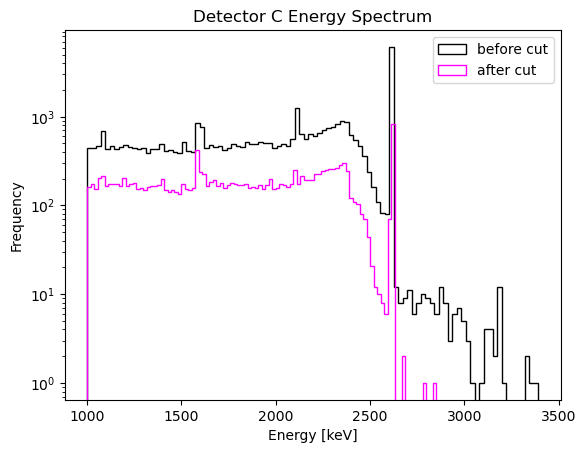

In [21]:
plt.figure()
ax = data_C['energy'].plot(
    kind='hist', 
    title='Detector C Energy Spectrum', 
    bins=100, 
    logy=True, 
    histtype='step',
    label='before cut',
    xlabel="Energy [keV]",
    color="black"
)

data_C_with_cut['energy'].plot(
    kind='hist', 
    ax=ax, 
    bins=100, 
    histtype='step',
    logy=True, 
    label='after cut',
    xlabel="Energy [keV]",
    color="magenta"
)

plt.legend()
plt.show()

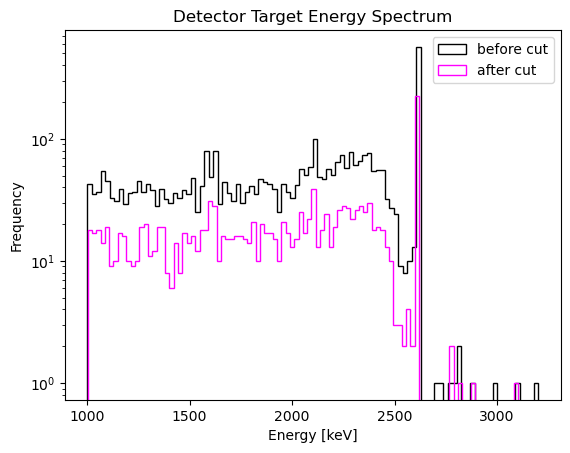

In [22]:
plt.figure()
ax = data_Target['energy'].plot(
    kind='hist', 
    title='Detector Target Energy Spectrum', 
    bins=100, 
    logy=True, 
    histtype='step',
    label='before cut',
    xlabel="Energy [keV]",
    color="black"
)

data_Target_with_cut['energy'].plot(
    kind='hist', 
    ax=ax, 
    bins=100, 
    histtype='step',
    logy=True, 
    label='after cut',
    xlabel="Energy [keV]",
    color="magenta"
)

plt.legend()
plt.show()

Step 5: PDF for detectors (are they all the same?)

In [ ]:
def detectorA_pdf(x, A, B, C, D):
    E0 = 1592
    sigma = 1 #ADJST THIS AS NEEDED
    peak = A*stats.norm.pdf(x, loc=E0, scale=sigma)

    # bkg = B*np.ones(len(x)) #ADJUST HEIGHT AS NEEDED
    bkg = B*x + C
    bkg2 = (1-A)*np.exp(-x/D)

    return peak+bkg +bkg2

Step 6: Perform the fit

In [31]:
pip install iminuit

Note: you may need to restart the kernel to use updated packages.


In [33]:
from iminuit import Minuit

In [89]:
def fit_function(x, thetaC, thetaNLDBD, A1, A2, A3, B1, B2, B3, C1, C2, C3, D1, D2, D3):
    thetaA = 1350 #where does uncertainty come in 
    thetaB = 770 #where does uncertainty come in

    return thetaA*detectorA_pdf(x, A1, B1, C1, D1) + thetaB*detectorA_pdf(x, A2, B2, C2, D2) + thetaC*detectorA_pdf(x, A3, B3, C3, D3) + thetaNLDBD*nldbd_pdf(x)

In [118]:
n_bins=100
# counts, bin_edges = np.histogram(data_Target_with_cut['energy'], bins=n_bins) 
counts, bin_edges = np.histogram(data_Target_with_cut['energy'], bins=n_bins, range=(1000,2400)) 
 
bin_width = (bin_edges[-1] - bin_edges[0]) / n_bins
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

def chi2(thetaC, thetaNLDBD, A1, A2, A3, B1, B2, B3, C1, C2, C3, D1, D2, D3):
    expected = fit_function(bin_centers, thetaC, thetaNLDBD, A1, A2, A3, B1, B2, B3, C1, C2, C3, D1, D2, D3)
    actual = counts
    chi2_value = np.sum(((actual - expected) ** 2) / expected)
    return chi2_value


minuit = Minuit(chi2, thetaC=1, thetaNLDBD=1, A1=1, A2=1, A3=1, B1=1, B2=1, B3=1, C1=1, C2=1, C3=1, D1=1, D2=1, D3=1)
minuit.limits = [(0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None), (0, None),(0, None), (0, None), (0, None), (0, None), (0, None), (0, None)]

minuit.migrad()  # Minimization

# Print the fit results
best_fit_thetaC = minuit.values["thetaC"]
best_fit_thetaNLDBD = minuit.values["thetaNLDBD"]
best_fit_A1 = minuit.values["A1"]
best_fit_B1 = minuit.values["B1"]
best_fit_C1 = minuit.values["C1"]
best_fit_D1 = minuit.values["D1"]
best_fit_A2 = minuit.values["A2"]
best_fit_B2 = minuit.values["B2"]
best_fit_C2 = minuit.values["C2"]
best_fit_D2 = minuit.values["D2"]
best_fit_A3 = minuit.values["A3"]
best_fit_B3 = minuit.values["B3"]
best_fit_C3 = minuit.values["C3"]
best_fit_D3 = minuit.values["D3"]

print(f"Best-fit thetaC: {best_fit_thetaC:.2f}")
print(f"Best-fit thetaNLDBD: {best_fit_thetaNLDBD:.2f}")
print(f"Best-fit A1: {best_fit_A1:.2f}")
print(f"Best-fit B1: {best_fit_B1:.2f}")
print(f"Best-fit C1: {best_fit_C1:.2f}")
print(f"Best-fit D1: {best_fit_D1:.2f}")
print(f"Best-fit A2: {best_fit_A2:.2f}")
print(f"Best-fit B2: {best_fit_B2:.2f}")
print(f"Best-fit C2: {best_fit_C2:.2f}")
print(f"Best-fit D2: {best_fit_D2:.2f}")
print(f"Best-fit A3: {best_fit_A3:.2f}")
print(f"Best-fit B3: {best_fit_B3:.2f}")
print(f"Best-fit C3: {best_fit_C3:.2f}")
print(f"Best-fit D3: {best_fit_D3:.2f}")

# Print the best-fit chi-square value
chi2_min = minuit.fval

print (f"Best-fit chi-square: {chi2_min:.2f}")

Best-fit thetaC: 0.02
Best-fit thetaNLDBD: 73.67
Best-fit A1: 0.78
Best-fit B1: 0.00
Best-fit C1: 0.00
Best-fit D1: 1.00
Best-fit A2: 0.79
Best-fit B2: 0.00
Best-fit C2: 0.00
Best-fit D2: 1.00
Best-fit A3: 0.02
Best-fit B3: 0.02
Best-fit C3: 0.02
Best-fit D3: 1.00
Best-fit chi-square: 122.39


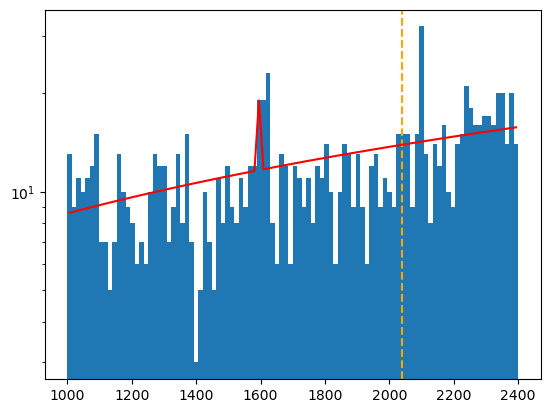

In [119]:

plt.axvline(x=2039, color="orange", linestyle="dashed")
plt.plot(bin_centers, fit_function(bin_centers, best_fit_thetaC, best_fit_thetaNLDBD, best_fit_A1, best_fit_A2, best_fit_A3, best_fit_B1, best_fit_B2, best_fit_B3, best_fit_C1, best_fit_C2, best_fit_C3, best_fit_D1, best_fit_D2, best_fit_D3), color='red')
plt.bar(bin_centers, counts, width=bin_width)

plt.yscale('log')
plt.show()

In [ ]:
m=best_fit_thetaNLDBD/cut_eff #number of NLDBD
print(m)

95.7981607330801
